In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11813945387780068094
]


In [2]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, SpatialDropout1D, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.metrics import multilabel_confusion_matrix, ndcg_score, classification_report
from keras.callbacks import EarlyStopping
import tqdm
from nltk.corpus import stopwords
import re
import tqdm
import spacy
import matplotlib.pyplot as plt

In [34]:
fn = '20211218_full'
df_train = pd.read_pickle(f'data/train_{fn}.pkl')
df_test= pd.read_pickle(f'data/test_{fn}.pkl')

In [35]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
filler_text_re = re.compile('buy: |pitchfork may .* affiliate')
DROP_TEXTS = [BAD_SYMBOLS_RE, filler_text_re]
STOPWORDS = set(stopwords.words('english'))

def clean_description(text):
    for drop_text in DROP_TEXTS:
        text = drop_text.sub('', text)
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text


tqdm.tqdm.pandas()
df_train['body_clean'] = df_train['body_paragraph_breaks'].progress_apply(clean_description)
df_test['body_clean'] = df_test['body_paragraph_breaks'].progress_apply(clean_description)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6043/6043 [00:02<00:00, 2751.10it/s]


In [ ]:
print(df_test['body_clean'][:5])
print(df_train['body_clean'].apply(len).describe())
VOCAB_SIZE = 50000
MAX_REVIEW_LENGTH = 1000


In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [38]:
tokenizer.fit_on_texts(df_train['body_clean'].values)
word_index = tokenizer.word_index
print('found %s unique tokens' % len(word_index))

found 353883 unique tokens


In [39]:
X_train = tokenizer.texts_to_sequences(df_train['body_clean'].values)
X_test = tokenizer.texts_to_sequences(df_test['body_clean'].values)
X_train = pad_sequences(X_train, maxlen=MAX_REVIEW_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_REVIEW_LENGTH)
print('train-data shape:', X_train.shape)
print('test-data shape:', X_test.shape)

Shape of data tensor: (9897, 2000)


In [40]:
(X_train[:,0] > 0).mean()

0.012633785722167053

In [41]:
genres = ['Rap','Rock','Global','Folk/Country','Electronic','Experimental','Metal','Pop/R&B','Jazz']

In [42]:
Y_train = df_train[genres].values
Y_test = df_test[genres].values
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (9897, 9)


In [43]:
EMBEDDING_DIM = 100

embeddings_index = {}
import numpy as np
with open(fr"C:\Users\follm\Documents\coding\embeddings\glove.6b\glove.6B.{EMBEDDING_DIM}d.txt", encoding='utf8') as f:
    for line in tqdm.tqdm(f.readlines()):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, i in tqdm.tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [00:18<00:00, 21812.74it/s]


Found 400000 word vectors.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 353883/353883 [00:00<00:00, 762434.83it/s]


In [100]:

model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_REVIEW_LENGTH,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1000, 100)         35388400  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 1000, 100)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               5632      
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 4617      
Total params: 35,403,089
Trainable params: 14,689
Non-trainable params: 35,388,400
_________________________________________________________________


In [ ]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])


Epoch 1/5
284/284 [==============================] - 624s 2s/step - loss: 1.9009 - accuracy: 0.4581 - val_loss: 1.8350 - val_accuracy: 0.4536
Epoch 2/5
284/284 [==============================] - 706s 2s/step - loss: 1.8550 - accuracy: 0.4613 - val_loss: 1.8259 - val_accuracy: 0.4536
Epoch 3/5
284/284 [==============================] - 690s 2s/step - loss: 1.8212 - accuracy: 0.4613 - val_loss: 1.7112 - val_accuracy: 0.4536
Epoch 4/5
 50/284 [====>.........................] - ETA: 9:09 - loss: 1.7614 - accuracy: 0.4625

In [50]:
# ALTERNATE MODEL
batch_size = 32
hidden_dims = 250
epochs = 10

model1d = Sequential()

model1d.add(Embedding(len(word_index)+1, EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_REVIEW_LENGTH,
                    trainable=False))
model1d.add(Dropout(0.2))
model1d.add(Conv1D(512, 4,
                 padding='valid',
                 activation='relu',
                 strides=1))
model1d.add(GlobalMaxPooling1D())
model1d.add(Dense(512, activation='relu'))
model1d.add(Dropout(0.2))
model1d.add(Dense(Y.shape[1], activation='sigmoid'))
model1d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1d.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1000, 100)         35388400  
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 995, 256)          153856    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 497, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 494, 256)          262400    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)             

In [51]:
history = model1d.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(X_test, Y_test))


Epoch 1/10
567/567 [==============================] - 265s 467ms/step - loss: 1.6694 - accuracy: 0.4767 - val_loss: 1.3450 - val_accuracy: 0.5947
Epoch 2/10
567/567 [==============================] - 266s 469ms/step - loss: 1.3009 - accuracy: 0.6215 - val_loss: 1.2263 - val_accuracy: 0.6245
Epoch 3/10
567/567 [==============================] - 265s 467ms/step - loss: 1.1805 - accuracy: 0.6504 - val_loss: 1.2018 - val_accuracy: 0.6321
Epoch 4/10
567/567 [==============================] - 262s 462ms/step - loss: 1.0989 - accuracy: 0.6656 - val_loss: 1.2427 - val_accuracy: 0.6110
Epoch 5/10
567/567 [==============================] - 244s 431ms/step - loss: 1.0313 - accuracy: 0.6805 - val_loss: 1.2320 - val_accuracy: 0.6199
Epoch 6/10
567/567 [==============================] - 234s 413ms/step - loss: 0.9674 - accuracy: 0.6912 - val_loss: 1.2394 - val_accuracy: 0.6318
Epoch 7/10
567/567 [==============================] - 240s 423ms/step - loss: 0.8994 - accuracy: 0.7088 - val_loss: 1.2733 -

KeyboardInterrupt: 

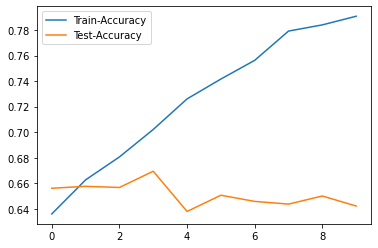

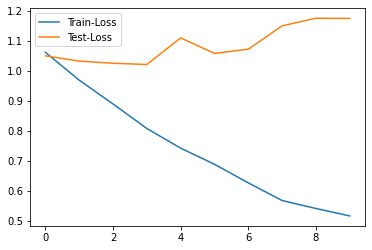

In [98]:

plt.plot(history.history['accuracy'], label='Train-Accuracy')
plt.plot(history.history['val_accuracy'], label='Test-Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train-Loss')
plt.plot(history.history['val_loss'], label='Test-Loss')
plt.legend()
plt.show()

In [90]:

print(list(','.join([f'{i}: {g}']) for i, g in enumerate(genres)))
print(classification_report(Y_test, y_pred>.33))

['0: Rap', '1: Rock', '2: Global', '3: Folk/Country', '4: Electronic', '5: Experimental', '6: Metal', '7: Pop/R&B', '8: Jazz']
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       583
           1       0.68      0.87      0.76      2754
           2       0.33      0.03      0.05        68
           3       0.42      0.21      0.28       249
           4       0.52      0.64      0.57      1176
           5       0.39      0.38      0.39       659
           6       0.57      0.57      0.57       254
           7       0.41      0.27      0.33       535
           8       0.55      0.30      0.38       159

   micro avg       0.61      0.66      0.63      6437
   macro avg       0.52      0.45      0.46      6437
weighted avg       0.59      0.66      0.62      6437
 samples avg       0.61      0.62      0.60      6437



C:\Users\follm\miniconda3\envs\py38tf2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\follm\miniconda3\envs\py38tf2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
multilabel_confusion_matrix(Y_test, y_pred>.33)

array([[[5357,  103],
        [ 111,  472]],

       [[2160, 1129],
        [ 354, 2400]],

       [[5971,    4],
        [  66,    2]],

       [[5723,   71],
        [ 197,   52]],

       [[4164,  703],
        [ 425,  751]],

       [[4997,  387],
        [ 408,  251]],

       [[5681,  108],
        [ 110,  144]],

       [[5300,  208],
        [ 389,  146]],

       [[5845,   39],
        [ 112,   47]]], dtype=int64)

In [53]:
y_pred = model1d.predict(X_test)

In [64]:
Y_test.sum(axis=1).mean()

1.0651994042694026

In [58]:
Y_test.sum()

6437

In [63]:
(y_pred > .33).sum(axis=1).mean()

1.161178222737051

In [52]:
model1d.evaluate(X_test,Y_test)

189/189 [==============================] - 21s 110ms/step - loss: 1.4031 - accuracy: 0.6345


[1.4030890464782715, 0.6344530582427979]

In [16]:
import keras
import tensorflow as tf
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Loading data...
17465344/17464789 [==============================] - 2s 0us/step
25000 train sequences
25000 test sequences


In [27]:
plot(df)


400